<a href="https://colab.research.google.com/github/cmclellen/AngularFormValidation/blob/master/220131_HousePrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras import layers, losses, optimizers 

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"craigmclellen","key":"224b95b7805a5779e3638aa1f0882a57"}'}

In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle

In [4]:
!kaggle competitions list -s house

ref                                          deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
house-prices-advanced-regression-techniques  2030-01-01 00:00:00  Getting Started  Knowledge       4859            True  
costa-rican-household-poverty-prediction     2018-09-19 23:59:00  Playground            Swag        616           False  


In [5]:
!kaggle competitions download house-prices-advanced-regression-techniques

  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 66.1MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 64.2MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 32.2MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 13.5MB/s]


In [422]:
train_ds = pd.read_csv('train.csv')
test_ds = pd.read_csv('test.csv')
sample_submission_ds = pd.read_csv('sample_submission.csv')

train_ds.shape, test_ds.shape, sample_submission_ds.shape

((1460, 81), (1459, 80), (1459, 2))

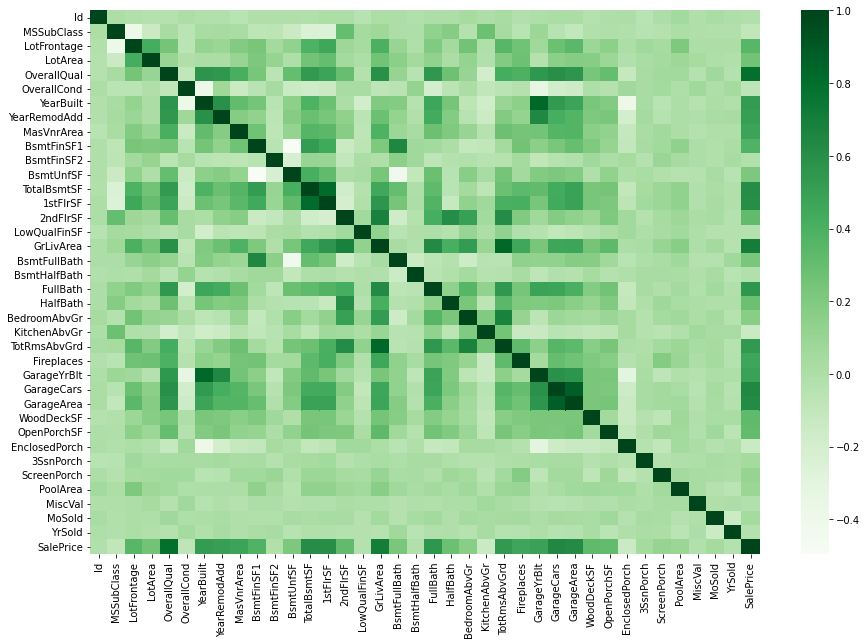

In [423]:
plt.figure(figsize=(15,10))
corr = train_ds.corr()
sns.heatmap(corr, cmap='Greens')

In [424]:
def get_cols(ds):
  categorical_cols = []
  numerical_cols = []
  for col in ds.columns:
    if ds[col].dtype=='object':
      categorical_cols.append(col)
    else:
      numerical_cols.append(col)
  return categorical_cols, numerical_cols

categorical_cols, numerical_cols = get_cols(train_ds)

print('categorical: ', categorical_cols)
print('numerical: ', numerical_cols)

categorical:  ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
numerical:  ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'Woo

In [425]:
corr['SalePrice'].nlargest(20)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
Name: SalePrice, dtype: float64

In [426]:
train_ID = train_ds['Id']
test_ID = test_ds['Id']

train_ds.drop('Id', axis=1, inplace=True)
test_ds.drop('Id', axis=1, inplace=True)

In [427]:
df_concat = pd.concat((train_ds, test_ds)).reset_index(drop=True)
df_concat.drop(['SalePrice', 'GarageArea'], axis=1, inplace=True)
df_concat[1455:1460]

# cols = ['ExterCond', 'LotFrontage', 'Neighborhood',
#         'MSZoning', 'OverallQual', 'OverallCond', 'GrLivArea', 
#         'BldgType', 'GarageCars', 'TotalSF', 'TotRmsAbvGrd', 'YearBuilt', 
#         'FullBath', 'HalfBath', 'BsmtHalfBath', 'BsmtFullBath', 'OpenPorchSF', 'WoodDeckSF', 'Fireplaces']

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,953.0,953.0,GasA,Ex,Y,SBrkr,953,694,0,1647,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2.0,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790.0,Rec,163.0,589.0,1542.0,GasA,TA,Y,SBrkr,2073,0,0,2073,1.0,0.0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2.0,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275.0,Unf,0.0,877.0,1152.0,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0.0,0.0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1.0,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49.0,Rec,1029.0,0.0,1078.0,GasA,Gd,Y,FuseA,1078,0,0,1078,1.0,0.0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1.0,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
1459,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830.0,LwQ,290.0,136.0,1256.0,GasA,Gd,Y,SBrkr,1256,0,0,1256,1.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1.0,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal


In [428]:
items = df_concat[['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']]
df_concat.TotalBsmtSF.fillna(0, inplace=True)
df_concat['TotalSF'] = df_concat['TotalBsmtSF'] + df_concat['1stFlrSF'] + df_concat['2ndFlrSF']
df_concat.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

# remaining_cols = set(df_concat.columns).difference(set(cols))
# len(remaining_cols), remaining_cols

In [429]:
# df_concat = df_concat[cols]
# df_concat.describe(include='all')

In [430]:
df_concat['GarageCars'].fillna(0, inplace=True)
df_concat['BsmtHalfBath'].fillna(0, inplace=True)
df_concat['BsmtFullBath'].fillna(0, inplace=True)
df_concat['MSZoning'].fillna('RL', inplace=True)

In [431]:
df_concat['LotFrontage'] = df_concat.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df_concat.drop('Neighborhood', axis=1, inplace=True)

In [432]:
missing = df_concat.isna().sum()
missing[missing > 0]

Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

# Get rid of all other NA

In [433]:
missing = df_concat.isna().sum()
cols_to_remove = missing[missing>0].sort_values(ascending=False)
df_concat.drop(cols_to_remove.index, axis=1, inplace=True)

In [434]:
# Don't delet rows, cause that'll remove the rows from test set too

# rows_to_drop = df_concat[df_concat.isna().any(axis=1)]
# df_concat.drop(rows_to_drop.index, inplace=True)

In [435]:
missing = df_concat.isna().sum()
missing[missing>0]

Series([], dtype: int64)

# Data prep

In [436]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

categorical_cols, numerical_cols = get_cols(df_concat)
print(categorical_cols)
print(numerical_cols)

ct = make_column_transformer(
  (MinMaxScaler(), numerical_cols),
  (OneHotEncoder(handle_unknown='ignore'), categorical_cols)
)

ct.fit(df_concat)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'PavedDrive', 'SaleCondition']
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'TotalSF']


ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['MSSubClass', 'LotFrontage', 'LotArea',
                                  'OverallQual', 'OverallCond', 'YearBuilt',
                                  'YearRemodAdd', 'LowQualFinSF', 'GrLivArea',
                                  'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
                                  'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
                                  'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
                                  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                                  '...lArea',
                                  'MiscVal', 'MoSold', 'YrSold', 'TotalSF']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['MSZoning', 'Street', 'LotShape',
                                  'LandContour', 'LotConfig', 'LandSlope',
 

In [437]:
X_normal = ct.transform(df_concat)
print(ct.get_feature_names_out())
X_normal.shape

['minmaxscaler__MSSubClass' 'minmaxscaler__LotFrontage'
 'minmaxscaler__LotArea' 'minmaxscaler__OverallQual'
 'minmaxscaler__OverallCond' 'minmaxscaler__YearBuilt'
 'minmaxscaler__YearRemodAdd' 'minmaxscaler__LowQualFinSF'
 'minmaxscaler__GrLivArea' 'minmaxscaler__BsmtFullBath'
 'minmaxscaler__BsmtHalfBath' 'minmaxscaler__FullBath'
 'minmaxscaler__HalfBath' 'minmaxscaler__BedroomAbvGr'
 'minmaxscaler__KitchenAbvGr' 'minmaxscaler__TotRmsAbvGrd'
 'minmaxscaler__Fireplaces' 'minmaxscaler__GarageCars'
 'minmaxscaler__WoodDeckSF' 'minmaxscaler__OpenPorchSF'
 'minmaxscaler__EnclosedPorch' 'minmaxscaler__3SsnPorch'
 'minmaxscaler__ScreenPorch' 'minmaxscaler__PoolArea'
 'minmaxscaler__MiscVal' 'minmaxscaler__MoSold' 'minmaxscaler__YrSold'
 'minmaxscaler__TotalSF' 'onehotencoder__MSZoning_C (all)'
 'onehotencoder__MSZoning_FV' 'onehotencoder__MSZoning_RH'
 'onehotencoder__MSZoning_RL' 'onehotencoder__MSZoning_RM'
 'onehotencoder__Street_Grvl' 'onehotencoder__Street_Pave'
 'onehotencoder__LotSha

(2919, 132)

In [438]:
train_normal = X_normal[:len(train_ID)]
test_normal = X_normal[len(train_ID):]

train_normal.shape, test_normal.shape

((1460, 132), (1459, 132))

In [439]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_normal, train_ds['SalePrice'], test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1168, 132), (292, 132), (1168,), (292,))

In [440]:
model_0 = tf.keras.Sequential([
  layers.Dense(100, activation='relu'),
  layers.Dense(10, activation='relu'),
  layers.Dense(1, activation='linear')
])

model_0.compile(loss=losses.mae,
                optimizer=optimizers.Adam(learning_rate=1e-1),
                metrics=['mae'])

es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_cb = tf.keras.callbacks.ReduceLROnPlateau(patience=5, monitor='val_loss', min_lr=1e-5)

model_0_fit = model_0.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), callbacks=[lr_cb, es_cb])

# 23553.1719
# 21672.6387
# 17448.3223

Epoch 1/1000
37/37 [==============================] - 1s 6ms/step - loss: 141043.7188 - mae: 141043.7188 - val_loss: 63949.2344 - val_mae: 63949.2344 - lr: 0.1000
Epoch 2/1000
37/37 [==============================] - 0s 3ms/step - loss: 45563.1172 - mae: 45563.1172 - val_loss: 40020.6328 - val_mae: 40020.6328 - lr: 0.1000
Epoch 3/1000
37/37 [==============================] - 0s 3ms/step - loss: 33511.0391 - mae: 33511.0391 - val_loss: 33107.3203 - val_mae: 33107.3203 - lr: 0.1000
Epoch 4/1000
37/37 [==============================] - 0s 4ms/step - loss: 30389.6328 - mae: 30389.6328 - val_loss: 31011.7090 - val_mae: 31011.7090 - lr: 0.1000
Epoch 5/1000
37/37 [==============================] - 0s 3ms/step - loss: 28443.7988 - mae: 28443.7988 - val_loss: 29829.0820 - val_mae: 29829.0820 - lr: 0.1000
Epoch 6/1000
37/37 [==============================] - 0s 3ms/step - loss: 26608.4141 - mae: 26608.4141 - val_loss: 29622.0957 - val_mae: 29622.0957 - lr: 0.1000
Epoch 7/1000
37/37 [============

# Submit

In [441]:
model_0_preds = tf.squeeze(model_0.predict(test_normal))
model_0_preds

<tf.Tensor: shape=(1459,), dtype=float32, numpy=
array([114819.29 , 155317.95 , 168752.73 , ..., 168571.77 , 122511.695,
       241092.66 ], dtype=float32)>

In [442]:
sample_submission_ds.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [443]:
submission = sample_submission_ds.copy()
submission['SalePrice'] = model_0_preds

In [445]:
DATE='220131'

In [446]:
submission.to_csv(f'{DATE}_submission.csv', index=False)

In [448]:
!kaggle competitions submit house-prices-advanced-regression-techniques -f {DATE}'_submission.csv' -m {DATE}' submission'

100% 21.2k/21.2k [00:00<00:00, 79.5kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques